
'''
1. Understanding the Problem and Research:

Begin by thoroughly understanding the problem statement and the significance of mitigating adversarial attacks in road sign recognition systems.
Review existing literature, including the papers referenced in your project proposal, to gain insights into different adversarial attack methods and defense strategies.

2. Data Acquisition and Preprocessing:

Acquire datasets such as GTSRB, LISA, and Open Street Map (OSM) data. Ensure proper permissions and compliance with data usage policies.
Preprocess the data to ensure uniformity and compatibility across datasets. This may involve tasks such as resizing, normalization, and augmentation.

3. Model Selection and Development:

Choose appropriate deep learning models for road sign recognition. Convolutional Neural Networks (CNNs) are commonly used for this task due to their effectiveness in image classification.
Implement baseline CNN models for road sign recognition using frameworks like TensorFlow or PyTorch. Train these models on your dataset to establish performance benchmarks.

4. Adversarial Attack Generation:

Implement the Perceptual-Sensitive GAN method and Robust Physical Perturbations method for generating adversarial examples targeted at road sign recognition systems.
Follow the methodologies outlined in the referenced papers to generate adversarial examples.
Experiment with different parameters to explore the robustness and effectiveness of each method.

5. Evaluation of Attack Success Rate:

Compare the success rates of the two adversarial attack methods by evaluating their impact on the classification accuracy of road sign recognition systems.
Measure the success rate of each method under various conditions and scenarios to understand their strengths and weaknesses.
Analysis of Existing Algorithms and Vulnerabilities:

6. Analyze existing road sign recognition algorithms to identify vulnerabilities to adversarial attacks.

Investigate how different types of adversarial perturbations affect the performance of these algorithms.

7. Exploration of Defense Strategies:

Explore potential defense mechanisms and mitigation strategies against adversarial attacks on road sign recognition systems.
Experiment with techniques such as adversarial training, input preprocessing, and model ensembling to improve robustness against attacks.

8. Implementation and Evaluation:

Implement the identified defense strategies and evaluate their effectiveness in mitigating adversarial attacks.

Compare the performance of the defended models against adversarial attacks with the baseline models.

'''

## Import Library

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Resize, Compose
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
import random
from torch import optim
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

## Download Data Set

## Dataset Exploration

In [2]:
training_data = datasets.GTSRB(root="../data", split="train", download=True, transform=Compose([ToTensor(),Resize(size=(48,48))]))
test_data = datasets.GTSRB(root="../data", split="test", download=True, transform=Compose([ToTensor(),Resize(size=(48,48))]))

100%|██████████| 187490228/187490228 [00:11<00:00, 16580323.81it/s]


Extracting ../data/gtsrb/GTSRB-Training_fixed.zip to ../data/gtsrb


100%|██████████| 88978620/88978620 [00:06<00:00, 14286770.70it/s]


Extracting ../data/gtsrb/GTSRB_Final_Test_Images.zip to ../data/gtsrb


100%|██████████| 99620/99620 [00:00<00:00, 215275.92it/s]


Extracting ../data/gtsrb/GTSRB_Final_Test_GT.zip to ../data/gtsrb


In [7]:
label_map = {
    '0': '20_speed',
    '1': '30_speed',
    '2': '50_speed',
    '3': '60_speed',
    '4': '70_speed',
    '5': '80_speed',
    '6': '80_lifted',
    '7': '100_speed',
    '8': '120_speed',
    '9': 'no_overtaking_general',
    '10': 'no_overtaking_trucks',
    '11': 'right_of_way_crossing',
    '12': 'right_of_way_general',
    '13': 'give_way',
    '14': 'stop',
    '15': 'no_way_general',
    '16': 'no_way_trucks',
    '17': 'no_way_one_way',
    '18': 'attention_general',
    '19': 'attention_left_turn',
    '20': 'attention_right_turn',
    '21': 'attention_curvy',
    '22': 'attention_bumpers',
    '23': 'attention_slippery',
    '24': 'attention_bottleneck',
    '25': 'attention_construction',
    '26': 'attention_traffic_light',
    '27': 'attention_pedestrian',
    '28': 'attention_children',
    '29': 'attention_bikes',
    '30': 'attention_snowflake',
    '31': 'attention_deer',
    '32': 'lifted_general',
    '33': 'turn_right',
    '34': 'turn_left',
    '35': 'turn_straight',
    '36': 'turn_straight_right',
    '37': 'turn_straight_left',
    '38': 'turn_right_down',
    '39': 'turn_left_down',
    '40': 'turn_circle',
    '41': 'lifted_no_overtaking_general',
    '42': 'lifted_no_overtaking_trucks'
}

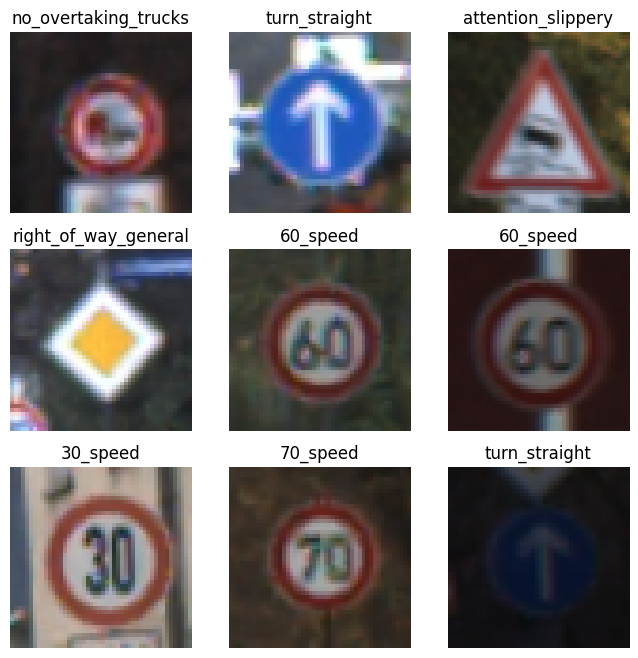

In [4]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label_map[f'{label}'])
    plt.axis("off")
    plt.imshow(img.permute(1,2,0), cmap="gray")
plt.show()

# Number of images per label before data augmentation

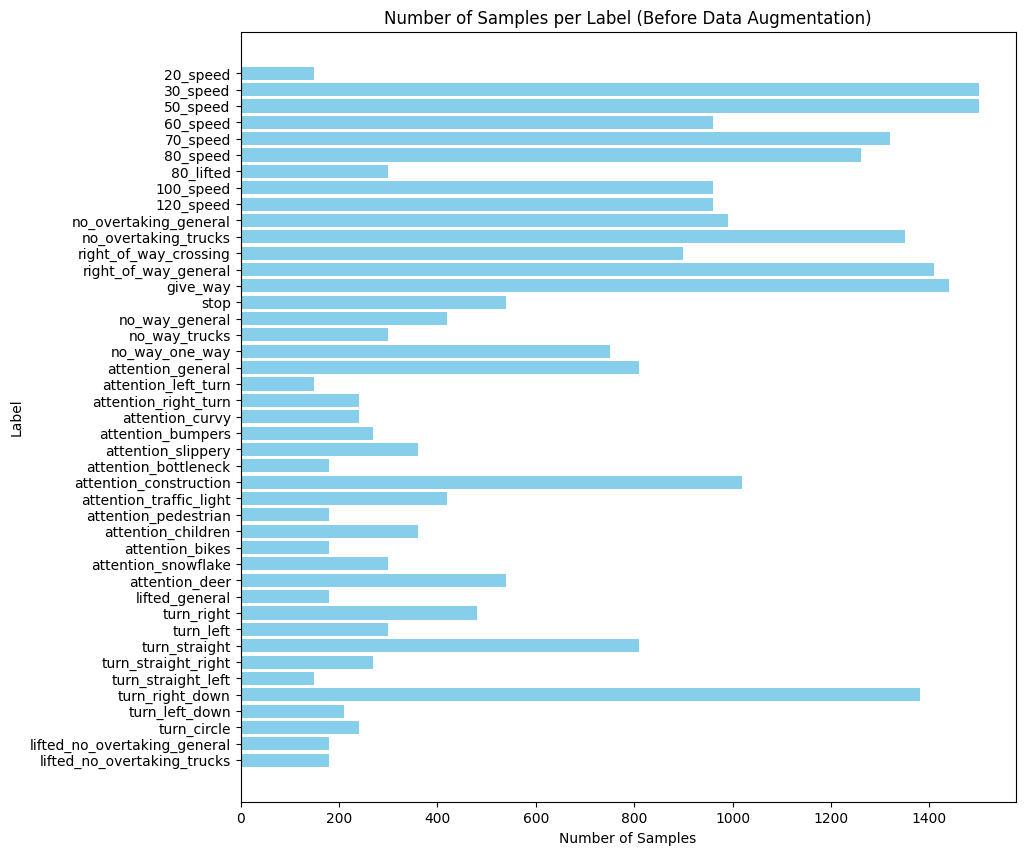

In [88]:
# Initialize counter
label_counts = Counter()

# Iterate through the dataset to count images for each label
for img_path, label in train_dataset:
    # Convert label to string
    label_str = str(label)
    # Check if label exists in the label map
    if label_str in label_map:
        # Get the label name from the label map
        label_name = label_map[label_str]
        # Increment the counter for the corresponding label
        label_counts[label_name] += 1

# Plot number of samples vs number of labels
labels = list(label_counts.keys())
counts = list(label_counts.values())

plt.figure(figsize=(10, 10))
plt.barh(labels, counts, color='skyblue')
plt.xlabel('Number of Samples')
plt.ylabel('Label')
plt.title('Number of Samples per Label (Before Data Augmentation)')
plt.gca().invert_yaxis()  # Invert y-axis to have labels ordered from top to bottom
plt.show()


# Data augmentation

In [8]:
from collections import Counter
from torchvision.transforms import ToTensor, Resize, Compose, RandomRotation, RandomHorizontalFlip, ColorJitter
from torch.utils.data import DataLoader
from torchvision.datasets import GTSRB

def count_samples_per_label_after_augmentation(root_dir, batch_size=64):
    # Define data augmentation transformations
    augmentation_transforms = Compose([
        RandomRotation(degrees=20),             # Random rotation up to 20 degrees
        RandomHorizontalFlip(p=0.5),            # Random horizontal flipping with a probability of 0.5
        ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)   # Color jitter
    ])

    # Apply data augmentation to training data
    augmented_training_data = GTSRB(root=root_dir, split="train", download=True, transform=Compose([augmentation_transforms, ToTensor(), Resize(size=(48,48))]))

    # Create DataLoader with augmented training data
    augmented_train_dataloader = DataLoader(augmented_training_data, batch_size=batch_size, shuffle=True)

    # Count the number of samples for each label after augmentation
    label_counts_after_augmentation = Counter()
    for _, label in augmented_training_data:
        label_counts_after_augmentation[label] += 1

    return label_counts_after_augmentation


#Data Distribution


In [4]:
from collections import Counter
from torchvision.transforms import ToTensor, Resize, Compose, RandomRotation, RandomHorizontalFlip, ColorJitter
from torch.utils.data import DataLoader
from torchvision.datasets import GTSRB
import matplotlib.pyplot as plt

def augment_data_for_even_distribution(root_dir, batch_size=64):
    # Define data augmentation transformations
    augmentation_transforms = Compose([
        RandomRotation(degrees=20),             # Random rotation up to 20 degrees
        RandomHorizontalFlip(p=0.5),            # Random horizontal flipping with a probability of 0.5
        ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)   # Color jitter
    ])
    label_map = {
        '0': '20_speed',
        '1': '30_speed',
        '2': '50_speed',
        '3': '60_speed',
        '4': '70_speed',
        '5': '80_speed',
        '6': '80_lifted',
        '7': '100_speed',
        '8': '120_speed',
        '9': 'no_overtaking_general',
        '10': 'no_overtaking_trucks',
        '11': 'right_of_way_crossing',
        '12': 'right_of_way_general',
        '13': 'give_way',
        '14': 'stop',
        '15': 'no_way_general',
        '16': 'no_way_trucks',
        '17': 'no_way_one_way',
        '18': 'attention_general',
        '19': 'attention_left_turn',
        '20': 'attention_right_turn',
        '21': 'attention_curvy',
        '22': 'attention_bumpers',
        '23': 'attention_slippery',
        '24': 'attention_bottleneck',
        '25': 'attention_construction',
        '26': 'attention_traffic_light',
        '27': 'attention_pedestrian',
        '28': 'attention_children',
        '29': 'attention_bikes',
        '30': 'attention_snowflake',
        '31': 'attention_deer',
        '32': 'lifted_general',
        '33': 'turn_right',
        '34': 'turn_left',
        '35': 'turn_straight',
        '36': 'turn_straight_right',
        '37': 'turn_straight_left',
        '38': 'turn_right_down',
        '39': 'turn_left_down',
        '40': 'turn_circle',
        '41': 'lifted_no_overtaking_general',
        '42': 'lifted_no_overtaking_trucks'
      }
    # Load the dataset
    training_data = GTSRB(root=root_dir, split="train", download=True, transform=Compose([ToTensor(), Resize(size=(48,48))]))

    # Count the number of samples for each label
    original_label_counts = Counter()
    for _, label in training_data:
      # Convert label to string
      label_str = str(label)
      # Check if label exists in the label map
      if label_str in label_map:
        # Get the label name from the label map
        label_name = label_map[label_str]
        # Increment the counter for the corresponding label
        original_label_counts[label_name] += 1

    # Calculate the desired number of samples per label for even distribution
    desired_samples_per_label = max(original_label_counts.values())

    # Augment the dataset to achieve even data distribution
    augmented_data = []
    augmented_label_counts = Counter()
    for img, label in training_data:
        augmented_data.append((img, label))
        augmented_label_counts[label] += 1
        while augmented_label_counts[label] < desired_samples_per_label:
            augmented_img = augmentation_transforms(img)
            augmented_data.append((augmented_img, label))
            augmented_label_counts[label] += 1


    # Create DataLoader with augmented data
    augmented_dataloader = DataLoader(augmented_data, batch_size=batch_size, shuffle=True)

    # Plot labels vs number of samples after data distribution
    labels = list(original_label_counts.keys())


    counts = [desired_samples_per_label] * len(labels)

    plt.figure(figsize=(10, 10))
    plt.barh(labels, counts, color='skyblue')
    plt.xlabel('Number of Samples')
    plt.ylabel('Label')
    plt.title('Number of Samples per Label (After Data Distribution)')
    plt.gca().invert_yaxis()  # Invert y-axis to have labels ordered from top to bottom
    plt.show()

    return augmented_dataloader


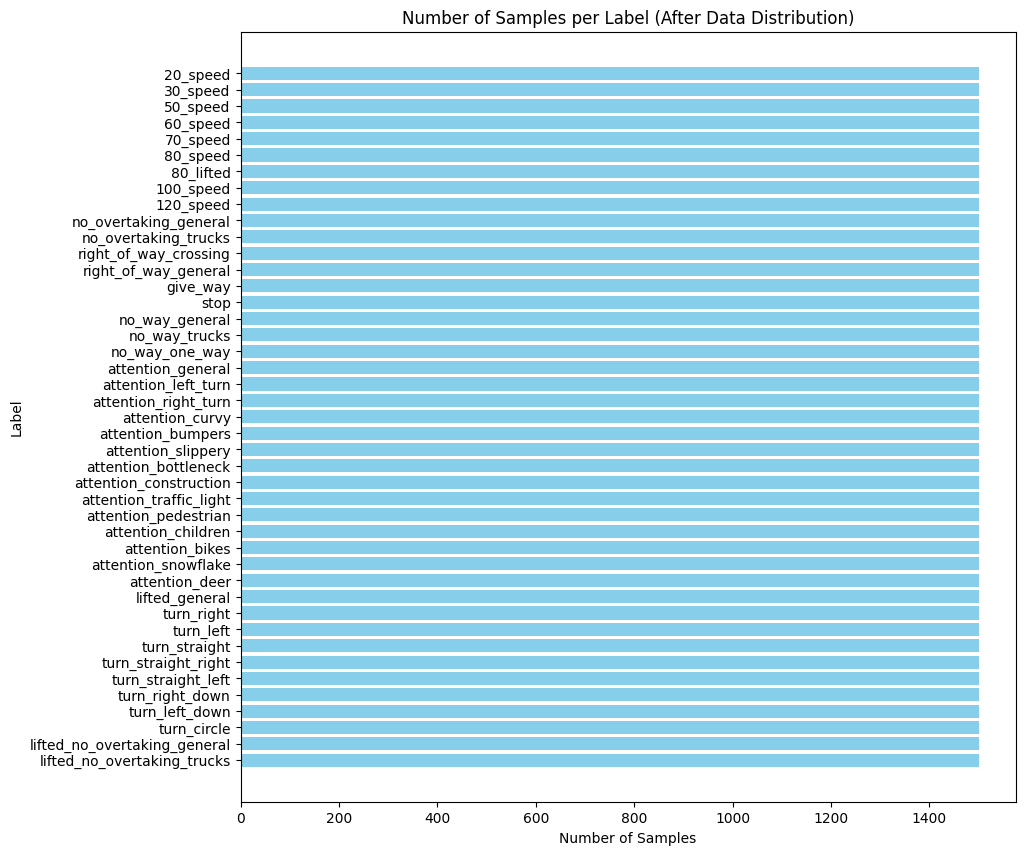

In [5]:
# Define the root directory of the GTSRB dataset
root_dir = "../data"

# Define the batch size
batch_size = 64

# Call the function to augment the data and achieve even distribution
augmented_dataloader = augment_data_for_even_distribution(root_dir, batch_size)


## Hyper-Parameters

In [ ]:
batch_size = 64
learning_rate = 0.001
weight_decay = 1e-5
epochs = 20

## Data Loaders

In [ ]:
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [ ]:
# Get cuda, mps or resort to cpu.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


## CNN Model

In [ ]:
class GTSRB_CNN(nn.Module):
    def __init__(self, in_channels=3):
        super(GTSRB_CNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3, padding=1),               # input size (_,3,48,48), output size (_,16,48,48)
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),                        # input size (_,16,48,48), output size (_,32,48,48)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                              # input size (_,32,48,48), output size (_,32,24,24)
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),                        # input size (_,32,24,24), output size (_,64,24,24)
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),                       # input size (_,64,24,24), output size (_,128,24,24)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                              # input size (_,128,24,24), output size (_,128,12,12)
            nn.BatchNorm2d(128),
            nn.Flatten(),                                                       # input size (_,128,12,12), output size (_,128*12*12)
            nn.Linear(18432,512),                                               # input size (_,128*12*12), output size (_,512)
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.5),
            nn.Linear(512,43),                                                  # input size (_,512), output size (_,43)
            nn.Softmax()
        )
    def forward(self, x):
        y = self.cnn(x)
        return y

In [ ]:
model = GTSRB_CNN().to(device)
print(model)

GTSRB_CNN(
  (cnn): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=18432, out_features=512, bias=True)
    (14): ReLU()
    (15): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (16): Dropout(p=0.5, inplace=False)

## Training

In [ ]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [ ]:
def train(dataloader, model, loss_func, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # Compute loss
        pred = model(X)
        loss = loss_func(pred, y)
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [ ]:
def test(dataloader, model, loss_func):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_func(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train(train_dataloader, model, loss_func, optimizer)
    test(test_dataloader, model, loss_func)
print("Done!")

In [ ]:
torch.save(model,'./model/GTSRB-CNN.pth')

## RP2 Algorithm Implementation

In [ ]:
def adversarial_attack(img,model,attack_epochs,target_label = 17,mask_filename="mask_trial.png",attack_lambda_l1 = 0.01,attack_lambda_l2 = 0.01):

    # Mask
    mask = torch.from_numpy(np.array(Image.open(f"{mask_filename}")))
    mask = mask.permute([2,0,1])/255.
    # mask = torch.ones_like(img)

    # Noise
    noise = nn.Parameter(torch.rand(img.shape))

    # Loss Function
    loss_func = nn.MSELoss()

    # Optimizer
    optimizer = optim.Adam([noise], lr=0.5)

    # Target Prediction
    target_pred = torch.zeros([1,43])
    target_pred[0][target_label] = 1

    # Pertrubation Optimization
    for i in range(attack_epochs):

        # Noisy Input
        masked_noise = torch.mul(mask,noise)
        noisy_img = torch.add(img,masked_noise)

        X, y = noisy_img.unsqueeze(0).to(device), target_pred.to(device)

        # Compute loss
        pred = model(X)
        loss = loss_func(pred, y) + attack_lambda_l2*torch.sqrt(torch.sum(torch.pow(masked_noise,2))) + attack_lambda_l1*torch.sum(torch.abs(masked_noise))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(f"attack epoch: {i}\t\tloss: {loss.item():>2f}")

    masked_noise = torch.mul(mask,noise)
    noisy_img = torch.add(img,masked_noise)
    pred = model(noisy_img.unsqueeze(0).to(device))
    # print(f"\nPredictions = {pred}")
    print(f"\nPrediction for the adversarial input: {pred.argmax(1)}")
    return noisy_img, masked_noise

Trial on one image

In [ ]:
train_set = next(iter(train_dataloader))

In [ ]:
train_set[1]

tensor([21,  2,  9, 11, 17, 21, 10,  0,  9,  5,  4, 28,  7,  4,  7,  9, 12, 12,
        16,  9,  2, 36, 33, 30,  1,  7, 23, 35, 25, 23, 13, 18, 25,  6, 12,  7,
        35, 13, 14,  3,  2, 14, 17,  8, 37,  4, 20, 38, 13,  4, 41,  9,  5,  9,
         5, 17, 10, 18, 13,  5,  3,  8, 11,  5])

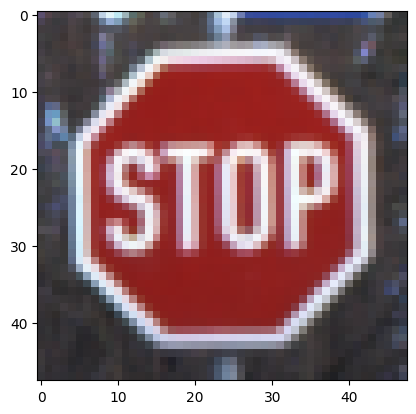

In [ ]:
img = train_set[0][41]
plt.imshow(img.permute((1,2,0)), cmap="gray")

Loading the trained model

In [ ]:
model = torch.load('GTSRB-CNN.pth',map_location=torch.device(device))

Running the adversarial algorithm

attack epoch: 0		loss: 0.046511
attack epoch: 1		loss: 0.046509
attack epoch: 2		loss: 0.046497
attack epoch: 3		loss: 0.046396
attack epoch: 4		loss: 0.045867
attack epoch: 5		loss: 0.034635
attack epoch: 6		loss: 0.032968
attack epoch: 7		loss: 0.039336
attack epoch: 8		loss: 0.033587
attack epoch: 9		loss: 0.031512
attack epoch: 10		loss: 0.030139
attack epoch: 11		loss: 0.040988
attack epoch: 12		loss: 0.030248
attack epoch: 13		loss: 0.032380
attack epoch: 14		loss: 0.036528
attack epoch: 15		loss: 0.032110
attack epoch: 16		loss: 0.032374
attack epoch: 17		loss: 0.031300
attack epoch: 18		loss: 0.031269
attack epoch: 19		loss: 0.032206
attack epoch: 20		loss: 0.032025
attack epoch: 21		loss: 0.031616
attack epoch: 22		loss: 0.030893
attack epoch: 23		loss: 0.030433
attack epoch: 24		loss: 0.030968
attack epoch: 25		loss: 0.030589
attack epoch: 26		loss: 0.030941
attack epoch: 27		loss: 0.030267
attack epoch: 28		loss: 0.029848
attack epoch: 29		loss: 0.029151
attack epoch: 30		lo

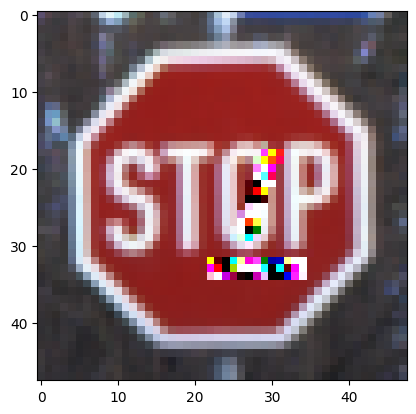

In [ ]:
noisy_image, masked_noise = adversarial_attack(img, model, attack_epochs = 100, target_label = 17, mask_filename="mask_trial.png", attack_lambda_l1 = 0., attack_lambda_l2 = 0.)
plt.imshow(noisy_image.detach().permute((1,2,0)), cmap="gray")